In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader, random_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, matthews_corrcoef

# Для визулизации слоёв нейронки
from torchsummary import summary

# Задаём RandomSeed
random.seed(52)
np.random.seed(52)
torch.manual_seed(52)
torch.cuda.manual_seed(52)
torch.backends.cudnn.deterministic = True

In [ ]:
# Центрирование и нормировка исходных данных
# Тут мы загружаем исходные данные нормируя по следующему алгоритму: 
# Вычитем среднее значение и поделим на его стандартное отклонение для каждого канала.

# Определяем преобразования для загрузки данных CIFAR-10
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Загружаем обучающий и тестовый наборы данных CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                           download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                          download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

100%|██████████| 170498071/170498071 [00:04<00:00, 39681909.21it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Часть №1 Оптимизация первичной структуры нейронной сети

In [ ]:
# Мы создаем функцию show_data для отображения изображения и его метки.
def show_data(img):
    try:
        # Пытаемся отобразить изображение, используя plt.imshow.
        plt.imshow(img[0])
    except Exception as e:
        # Если возникает ошибка, печатаем ее.
        print(e)
    # Выводим форму изображения и его форму после перестановки осей для корректного отображения.
    print(img[0].shape, img[0].permute(1,2,0).shape)
    # Отображаем изображение с помощью plt.imshow после перестановки осей.
    plt.imshow(img[0].permute(1,2,0))
    # Добавляем заголовок, содержащий метку (y) изображения.
    plt.title('y = '+ str(img[1]))
    # Отображаем график.
    plt.show()

# Функция im_convert используется для преобразования тензора изображения в формат numpy array для отображения с помощью matplotlib.
def im_convert(tensor):
    # Преобразуем тензор в массив numpy.
    img = tensor.cpu().clone().detach().numpy() #
    # Переставляем размерности массива, чтобы он стал совместим с matplotlib.
    img = img.transpose(1, 2, 0)
    # Применяем обратное преобразование нормализации, чтобы получить оригинальное изображение.
    img = img * np.array(tuple(mean)) + np.array(tuple(std))
    # Обрезаем значения пикселей изображения до диапазона [0, 1].
    img = img.clip(0, 1)
    # Возвращаем изображение в формате numpy array.
    return img


In [ ]:
# Посмотрим разметрность для загруженных данных
len(trainset), len(testset)
# Таким образом мы видим что размерности для загружаемых данных:
# -- 50к для обучающего набора
# -- 10к для тестового набора

(50000, 10000)

Invalid shape (3, 32, 32) for image data
torch.Size([3, 32, 32]) torch.Size([32, 32, 3])


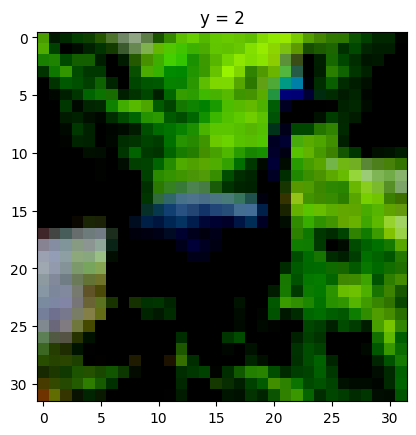

Invalid shape (3, 32, 32) for image data
torch.Size([3, 32, 32]) torch.Size([32, 32, 3])


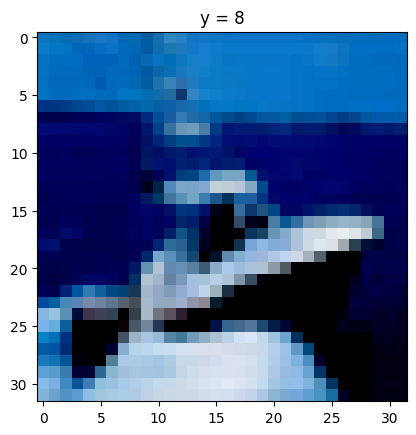

Invalid shape (3, 32, 32) for image data
torch.Size([3, 32, 32]) torch.Size([32, 32, 3])


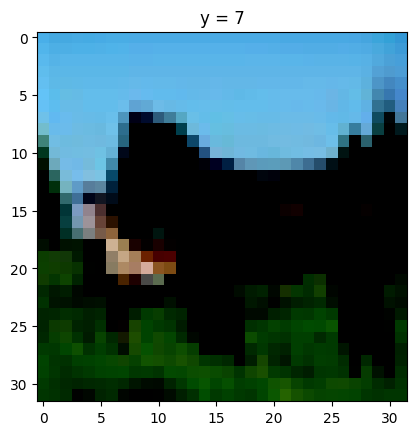

In [ ]:
# Визуализация примера изображений
show_data(trainset[6])
show_data(trainset[8])
show_data(trainset[12])

In [ ]:
# Посмотрим на имеюбщиеся в датасете классы
trainset.classes
# Так мы можем понять, что
# -- 1й рисунок имеет метку - 2 а значит относится к классу bird
# -- 2й рисунок имеет метку - 8 а значит относится к классу ship
# -- 3й рисунок имеет метку - 7 а значит относится к классу horse

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
# Для оценки ценности нормировки исходных значений обучим простейшую модель и посмотрим на её результат

# Определение модели
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)  # Первый свёрточный слой
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)                    # Пул-слой
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5) # Второй свёрточный слой
        self.fc1 = nn.Linear(16 * 5 * 5, 120)                               # Полносвязный слой
        self.fc2 = nn.Linear(120, 10)                                       # Выходной слой

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))                    # Пропускаем x через первый свёрточный слой и функцию активации ReLU
        x = self.pool(nn.functional.relu(self.conv2(x)))                    # Пропускаем x через второй свёрточный слой и функцию активации ReLU
        x = x.view(-1, 16 * 5 * 5)                                           # Преобразуем 2D-тензор в 1D-вектор
        x = nn.functional.relu(self.fc1(x))                                  # Пропускаем x через первый полносвязный слой и функцию активации ReLU
        x = self.fc2(x)                                                      # Пропускаем x через выходной слой
        return x

model = SimpleCNN()

Epoch [1], Loss: 1.6529, Test Accuracy: 47.68 %
Epoch [2], Loss: 1.3666, Test Accuracy: 53.72 %
Epoch [3], Loss: 1.2461, Test Accuracy: 56.88 %
Epoch [4], Loss: 1.1651, Test Accuracy: 58.37 %
Epoch [5], Loss: 1.1051, Test Accuracy: 60.20 %
Epoch [6], Loss: 1.0578, Test Accuracy: 61.61 %
Epoch [7], Loss: 1.0175, Test Accuracy: 61.81 %
Epoch [8], Loss: 0.9792, Test Accuracy: 62.66 %
Epoch [9], Loss: 0.9508, Test Accuracy: 63.79 %
Epoch [10], Loss: 0.9219, Test Accuracy: 63.97 %
Epoch [11], Loss: 0.8925, Test Accuracy: 63.62 %
Epoch [12], Loss: 0.8681, Test Accuracy: 64.22 %
Epoch [13], Loss: 0.8469, Test Accuracy: 65.46 %
Epoch [14], Loss: 0.8273, Test Accuracy: 65.25 %
Epoch [15], Loss: 0.8027, Test Accuracy: 65.22 %
Epoch [16], Loss: 0.7864, Test Accuracy: 64.27 %
Epoch [17], Loss: 0.7674, Test Accuracy: 65.36 %
Epoch [18], Loss: 0.7503, Test Accuracy: 65.68 %
Epoch [19], Loss: 0.7335, Test Accuracy: 65.46 %
Epoch [20], Loss: 0.7161, Test Accuracy: 64.73 %
Epoch [21], Loss: 0.7027, Tes

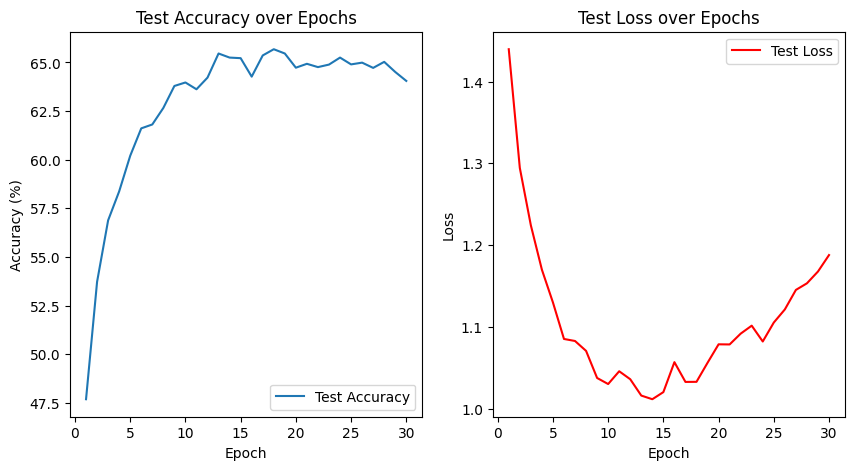

In [ ]:
def train(net, trainloader, testloader):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)

    test_accuracy_history = []
    test_loss_history = []

    for epoch in range(30):  # Устанавливаем значение в 30 эпох
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Оценка модели на тестовом наборе данных после каждой эпохи
        net.eval()
        correct = 0
        total = 0
        test_loss = 0.0
        with torch.no_grad():
            for data in testloader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += criterion(outputs, labels).item()

        test_accuracy = 100 * correct / total
        test_accuracy_history.append(test_accuracy)
        test_loss_history.append(test_loss / len(testloader))

        print('Epoch [%d], Loss: %.4f, Test Accuracy: %.2f %%' %
              (epoch + 1, running_loss / len(trainloader), test_accuracy))


    # Визуализация точности и потерь
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(test_accuracy_history) + 1), test_accuracy_history, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(test_loss_history) + 1), test_loss_history, label='Test Loss', color='r')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Test Loss over Epochs')
    plt.legend()

    plt.show()

# Используйте функцию train, чтобы обучить вашу модель
train(SimpleCNN(), trainloader, testloader)

In [ ]:
# Посмотрим на визуализацию струтктуры нейрнонной сети
# Предположим, что input_size = (3, 32, 32)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 10]           1,210
Total params: 52,202
Trainable params: 52,202
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.20
Estimated Total Size (MB): 0.27
----------------------------------------------------------------


Получившуюся точность нельзя считать достаточной, поэтому попробуем изменить архитектуру сети. Для этого попробуем добавть некоторые слои и посмотрим на результат

## Часть №2 Расширение архитектуры сети

In [ ]:
# Первым делом попробуем переделать класс нейронной сети изменив колличество её слоёв
# Для оценки ценности нормировки исходных значений обучим простейшую модель и посмотрим на её результат

class NotSimpleCNN(nn.Module):
    def __init__(self):
        super(NotSimpleCNN, self).__init__()
        # Сверточные слои
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # Пулинг слой
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Полносвязные слои
        self.fc1 = nn.Linear(64 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)
        # Нормализация между слоями
        self.batch_norm1 = nn.BatchNorm2d(16)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.batch_norm3 = nn.BatchNorm2d(64)

    def forward(self, x):
        # Пропускаем через первый сверточный слой с активацией и нормализацией
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        # Пропускаем через второй сверточный слой с активацией и нормализацией
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        # Пропускаем через третий сверточный слой с активацией и нормализацией
        x = self.pool(F.relu(self.batch_norm3(self.conv3(x))))
        # Выпрямляем для полносвязного слоя
        x = x.view(-1, 64 * 4 * 4)
        # Пропускаем через первый полносвязный слой с активацией
        x = F.relu(self.fc1(x))
        # Пропускаем через второй полносвязный слой
        x = self.fc2(x)
        return x

model = NotSimpleCNN()

Epoch [1], Loss: 1.2808, Test Accuracy: 60.36 %
Epoch [2], Loss: 0.9467, Test Accuracy: 67.38 %
Epoch [3], Loss: 0.7972, Test Accuracy: 70.32 %
Epoch [4], Loss: 0.6948, Test Accuracy: 72.49 %
Epoch [5], Loss: 0.6105, Test Accuracy: 72.58 %
Epoch [6], Loss: 0.5310, Test Accuracy: 73.83 %
Epoch [7], Loss: 0.4598, Test Accuracy: 73.50 %
Epoch [8], Loss: 0.3978, Test Accuracy: 73.11 %
Epoch [9], Loss: 0.3332, Test Accuracy: 73.94 %
Epoch [10], Loss: 0.2867, Test Accuracy: 72.49 %
Epoch [11], Loss: 0.2497, Test Accuracy: 73.06 %
Epoch [12], Loss: 0.2077, Test Accuracy: 72.56 %
Epoch [13], Loss: 0.1802, Test Accuracy: 72.45 %
Epoch [14], Loss: 0.1739, Test Accuracy: 72.11 %
Epoch [15], Loss: 0.1512, Test Accuracy: 72.88 %
Epoch [16], Loss: 0.1398, Test Accuracy: 72.53 %
Epoch [17], Loss: 0.1186, Test Accuracy: 73.22 %
Epoch [18], Loss: 0.1099, Test Accuracy: 71.95 %
Epoch [19], Loss: 0.1167, Test Accuracy: 71.35 %
Epoch [20], Loss: 0.1125, Test Accuracy: 72.28 %
Epoch [21], Loss: 0.1075, Tes

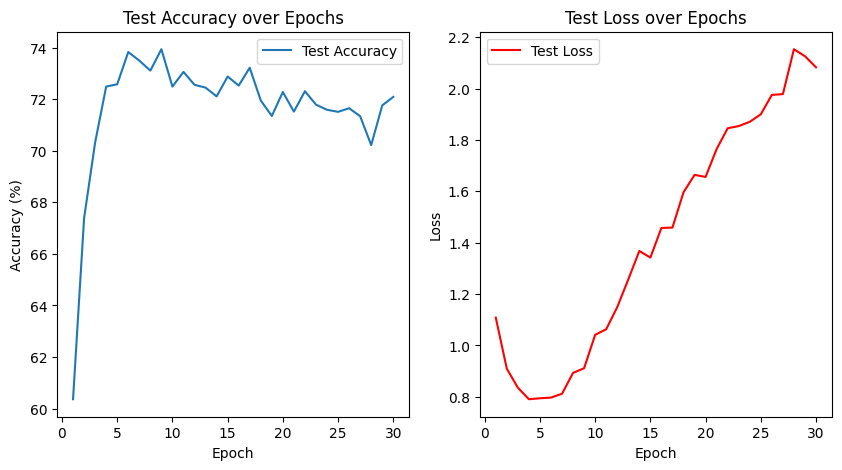

In [ ]:
def train(net, trainloader, testloader):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)

    test_accuracy_history = []
    test_loss_history = []

    for epoch in range(30):  # Примерно 10 эпох
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Оценка модели на тестовом наборе данных после каждой эпохи
        net.eval()
        correct = 0
        total = 0
        test_loss = 0.0
        with torch.no_grad():
            for data in testloader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += criterion(outputs, labels).item()

        test_accuracy = 100 * correct / total
        test_accuracy_history.append(test_accuracy)
        test_loss_history.append(test_loss / len(testloader))

        print('Epoch [%d], Loss: %.4f, Test Accuracy: %.2f %%' %
              (epoch + 1, running_loss / len(trainloader), test_accuracy))


    # Визуализация точности и потерь
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(test_accuracy_history) + 1), test_accuracy_history, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(test_loss_history) + 1), test_loss_history, label='Test Loss', color='r')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Test Loss over Epochs')
    plt.legend()

    plt.show()

# Используйте функцию train, чтобы обучить вашу модель
train(NotSimpleCNN(), trainloader, testloader)


In [ ]:
model = model.to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
       BatchNorm2d-5           [-1, 32, 16, 16]              64
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          18,496
       BatchNorm2d-8             [-1, 64, 8, 8]             128
         MaxPool2d-9             [-1, 64, 4, 4]               0
           Linear-10                  [-1, 256]         262,400
           Linear-11                   [-1, 10]           2,570
Total params: 288,778
Trainable params: 288,778
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

## Часть №3 Эксперименты с архитектурой и обучением

### Pooling

Теперь, после того как мы посмотрели влияние архитектуры на результаты обучения модели попробуем поигратсья с её параметрами первым из таких параметров, будет Pooling

In [ ]:
class PoolingCNN(nn.Module):
    def __init__(self, pooling_type='max'):
        super(PoolingCNN, self).__init__()
        # Сверточные слои
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # Выбор типа пулинга
        if pooling_type == 'max':
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pooling_type == 'avg':
            self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        else:
            raise ValueError("Invalid pooling type. Choose 'max' or 'avg'.")
        # Полносвязные слои
        self.fc1 = nn.Linear(32 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)
        # Нормализация между слоями
        self.batch_norm1 = nn.BatchNorm2d(16)
        self.batch_norm2 = nn.BatchNorm2d(32)

    def forward(self, x):
        # Пропускаем через первый сверточный слой с активацией и нормализацией
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        # Пропускаем через второй сверточный слой с активацией и нормализацией
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        # Выпрямляем для полносвязного слоя
        x = x.view(-1, 32 * 8 * 8)
        # Пропускаем через первый полносвязный слой с активацией
        x = F.relu(self.fc1(x))
        # Пропускаем через второй полносвязный слой
        x = self.fc2(x)
        return x


In [ ]:
def train(net, trainloader, testloader, pooling_type='max', num_epochs=30):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)

    test_accuracy_history = []
    test_loss_history = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Оценка модели на тестовом наборе данных после каждой эпохи
        net.eval()
        correct = 0
        total = 0
        test_loss = 0.0
        with torch.no_grad():
            for data in testloader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += criterion(outputs, labels).item()

        test_accuracy = 100 * correct / total
        test_accuracy_history.append(test_accuracy)
        test_loss_history.append(test_loss / len(testloader))

        print('Epoch [%d], Loss: %.4f, Test Accuracy: %.2f %%' %
              (epoch + 1, running_loss / len(trainloader), test_accuracy))

    # Возвращаем результаты обучения для построения графиков
    return test_accuracy_history, test_loss_history


Epoch [1], Loss: 1.3025, Test Accuracy: 61.63 %
Epoch [2], Loss: 0.9662, Test Accuracy: 65.68 %
Epoch [3], Loss: 0.8163, Test Accuracy: 70.12 %
Epoch [4], Loss: 0.7010, Test Accuracy: 69.72 %
Epoch [5], Loss: 0.5984, Test Accuracy: 71.02 %
Epoch [6], Loss: 0.4936, Test Accuracy: 71.45 %
Epoch [7], Loss: 0.4080, Test Accuracy: 69.52 %
Epoch [8], Loss: 0.3256, Test Accuracy: 70.20 %
Epoch [9], Loss: 0.2576, Test Accuracy: 69.45 %
Epoch [10], Loss: 0.1958, Test Accuracy: 69.16 %
Epoch [11], Loss: 0.1581, Test Accuracy: 68.08 %
Epoch [12], Loss: 0.1385, Test Accuracy: 69.16 %
Epoch [13], Loss: 0.1124, Test Accuracy: 68.61 %
Epoch [14], Loss: 0.1021, Test Accuracy: 68.86 %
Epoch [15], Loss: 0.0982, Test Accuracy: 68.33 %
Epoch [16], Loss: 0.0961, Test Accuracy: 68.07 %
Epoch [17], Loss: 0.0818, Test Accuracy: 68.20 %
Epoch [18], Loss: 0.0657, Test Accuracy: 68.58 %
Epoch [19], Loss: 0.0763, Test Accuracy: 68.39 %
Epoch [20], Loss: 0.0711, Test Accuracy: 68.78 %
Epoch [21], Loss: 0.0742, Tes

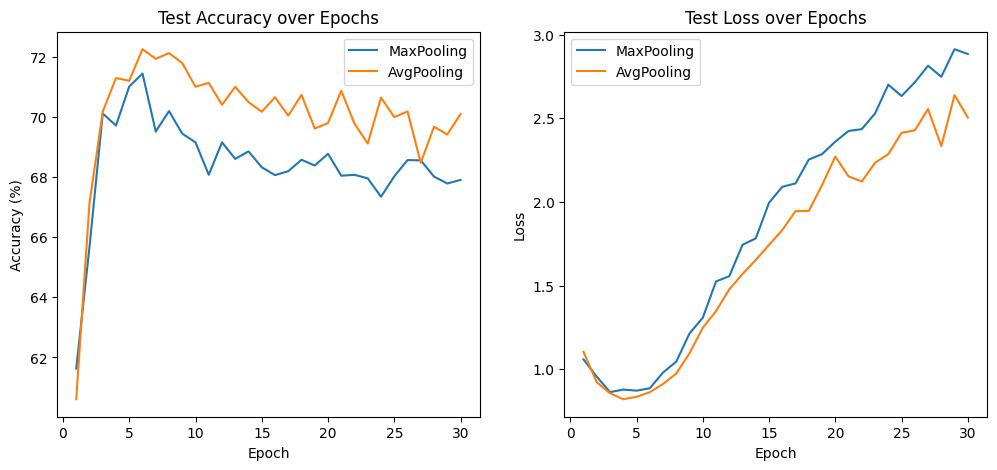

In [ ]:
# Создаем экземпляр модели с MaxPooling
net_max = PoolingCNN(pooling_type='max')

# Обучаем модель с MaxPooling
accuracies_max, losses_max = train(net_max, trainloader, testloader, pooling_type='max')

# Создаем экземпляр модели с AvgPooling
net_avg = PoolingCNN(pooling_type='avg')

# Обучаем модель с AvgPooling
accuracies_avg, losses_avg = train(net_avg, trainloader, testloader, pooling_type='avg')

# Строим график сравнения результатов
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(accuracies_max) + 1), accuracies_max, label='MaxPooling')
plt.plot(range(1, len(accuracies_avg) + 1), accuracies_avg, label='AvgPooling')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(losses_max) + 1), losses_max, label='MaxPooling')
plt.plot(range(1, len(losses_avg) + 1), losses_avg, label='AvgPooling')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss over Epochs')
plt.legend()

plt.show()

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = PoolingCNN().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
       BatchNorm2d-5           [-1, 32, 16, 16]              64
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Linear-7                  [-1, 256]         524,544
            Linear-8                   [-1, 10]           2,570
Total params: 532,298
Trainable params: 532,298
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.42
Params size (MB): 2.03
Estimated Total Size (MB): 2.47
----------------------------------------------------------------


В качестве архитектуры, используемой мной далее - буду использовать maxpoolig, а в заключительном слое - avgpooling

### DropOut и Оптимизаторы

In [ ]:
# Определение класса сети с Dropout
class CNNWithDropout(nn.Module):
    def __init__(self, p=0.5):  # Добавлен аргумент p для вероятности dropout
        super(CNNWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(p)  # Добавлен Dropout слой с вероятностью p

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)  # Применяем Dropout после первого полносвязного слоя
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Определение класса сети без Dropout
class CNNWithoutDropout(nn.Module):
    def __init__(self):
        super(CNNWithoutDropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Epoch [1], Loss: 2.3035, Test Accuracy: 9.97 %
Epoch [2], Loss: 2.3035, Test Accuracy: 10.00 %
Epoch [3], Loss: 2.3035, Test Accuracy: 10.02 %
Epoch [4], Loss: 2.3035, Test Accuracy: 10.01 %
Epoch [5], Loss: 2.3036, Test Accuracy: 10.01 %
Epoch [6], Loss: 2.3035, Test Accuracy: 9.99 %
Epoch [7], Loss: 2.3035, Test Accuracy: 9.98 %
Epoch [8], Loss: 2.3035, Test Accuracy: 10.00 %
Epoch [9], Loss: 2.3035, Test Accuracy: 10.00 %
Epoch [10], Loss: 2.3035, Test Accuracy: 9.98 %
Epoch [11], Loss: 2.3035, Test Accuracy: 9.98 %
Epoch [12], Loss: 2.3035, Test Accuracy: 10.01 %
Epoch [13], Loss: 2.3035, Test Accuracy: 10.04 %
Epoch [14], Loss: 2.3035, Test Accuracy: 10.01 %
Epoch [15], Loss: 2.3036, Test Accuracy: 10.01 %
Epoch [16], Loss: 2.3035, Test Accuracy: 10.03 %
Epoch [17], Loss: 2.3035, Test Accuracy: 9.97 %
Epoch [18], Loss: 2.3035, Test Accuracy: 9.99 %
Epoch [19], Loss: 2.3035, Test Accuracy: 9.96 %
Epoch [20], Loss: 2.3035, Test Accuracy: 10.00 %
Epoch [1], Loss: 2.3027, Test Accurac

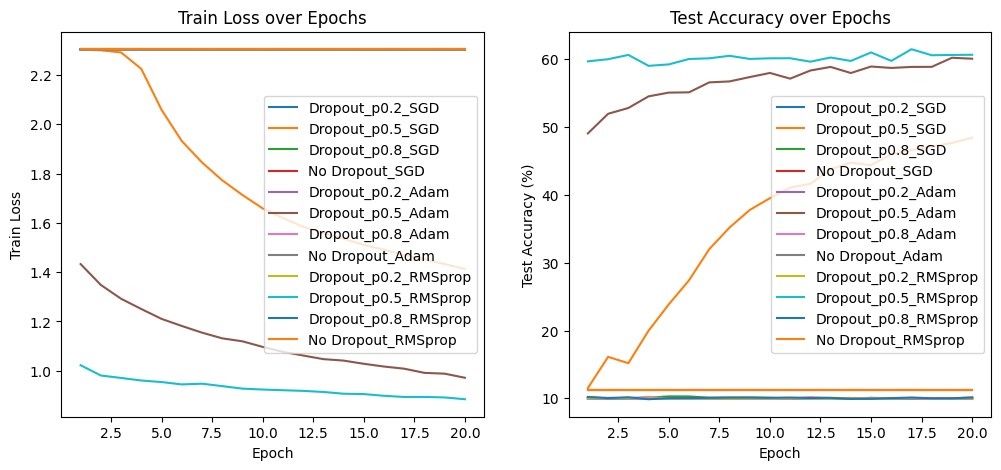

In [ ]:
# Функция обучения модели
def train_model(model, trainloader, testloader, optimizer, pooling_type):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer

    train_loss_history = []
    test_accuracy_history = []

    for epoch in range(20):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Оценка модели на тестовом наборе данных после каждой эпохи
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracy = 100 * correct / total
        test_accuracy_history.append(test_accuracy)
        train_loss_history.append(running_loss / len(trainloader))

        print('Epoch [%d], Loss: %.4f, Test Accuracy: %.2f %%' %
              (epoch + 1, running_loss / len(trainloader), test_accuracy))
        #print(f"Epoch {epoch+1}, Training Loss: {running_loss / len(trainloader)}, Test Accuracy: {test_accuracy}")

    return train_loss_history, test_accuracy_history

# Создаем экземпляры моделей с разными архитектурами и оптимизаторами
models = {
    'Dropout_p0.2': CNNWithDropout(p=0.2),  # Dropout с вероятностью 0.2
    'Dropout_p0.5': CNNWithDropout(p=0.5),  # Dropout с вероятностью 0.5
    'Dropout_p0.8': CNNWithDropout(p=0.8),  # Dropout с вероятностью 0.8
    'No Dropout': CNNWithoutDropout()
}

optimizers = {
    'SGD': optim.SGD(models['Dropout_p0.5'].parameters(), lr=0.001, momentum=0.9),
    'Adam': optim.Adam(models['Dropout_p0.5'].parameters(), lr=0.001),
    'RMSprop': optim.RMSprop(models['Dropout_p0.5'].parameters(), lr=0.001)
}

# Словари для хранения истории потерь и точности для каждой модели
train_loss_histories = {}
test_accuracy_histories = {}

# Обучаем каждую модель с каждым оптимизатором и сохраняем историю потерь и точности
for optimizer_name, optimizer in optimizers.items():
    for model_name, model in models.items():
        train_loss_histories[f'{model_name}_{optimizer_name}'], test_accuracy_histories[f'{model_name}_{optimizer_name}'] = train_model(model, trainloader, testloader, optimizer, pooling_type='max')

# Построим графики для сравнения результатов
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for key, train_loss_history in train_loss_histories.items():
    plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label=key)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
for key, test_accuracy_history in test_accuracy_histories.items():
    plt.plot(range(1, len(test_accuracy_history) + 1), test_accuracy_history, label=key)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy over Epochs')
plt.legend()

plt.show()

In [ ]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# model = CNNWithDropout().to(device)
# summary(model, input_size=(3, 32, 32))

In [ ]:
# model = CNNWithoutDropout().to(device)
# summary(model, input_size=(3, 32, 32))

### Аугментация

In [ ]:
# Загрузка данных CIFAR-10
transform_with_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_no_augmentation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset_with_augmentation = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_with_augmentation)
trainloader_with_augmentation = torch.utils.data.DataLoader(trainset_with_augmentation, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_no_augmentation)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Определение модели CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Files already downloaded and verified
Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [1], Loss: 1.6942, Test Accuracy: 48.88 %
Epoch [2], Loss: 1.3541, Test Accuracy: 54.40 %
Epoch [3], Loss: 1.2407, Test Accuracy: 58.20 %
Epoch [4], Loss: 1.1791, Test Accuracy: 57.80 %
Epoch [5], Loss: 1.1289, Test Accuracy: 61.37 %
Epoch [6], Loss: 1.0936, Test Accuracy: 61.75 %
Epoch [7], Loss: 1.0580, Test Accuracy: 62.41 %
Epoch [8], Loss: 1.0409, Test Accuracy: 62.37 %
Epoch [9], Loss: 1.0222, Test Accuracy: 62.25 %
Epoch [10], Loss: 1.0060, Test Accuracy: 63.97 %
Epoch [11], Loss: 0.9871, Test Accuracy: 64.47 %
Epoch [12], Loss: 0.9783, Test Accuracy: 64.73 %
Epoch [13], Loss: 0.9649, Test Accuracy: 62.90 %
Epoch [14], Loss: 0.9557, Test Accuracy: 64.55 %
Epoch [15], Loss: 0.9536, Test Accuracy: 65.64 %
Epoch [16], Loss: 0.9427, Test Accuracy: 65.67 %
Epoch [17], Loss: 0.9389, Test Accuracy: 65.37 %
Epoch [18], Loss: 0.9351, Test Accuracy: 63.95 %
Epoch [19], Loss: 0.9232, Test Accuracy: 65.19 %
Epoch [20], Loss: 0.9249, Test Accuracy: 64.90 %
Epoch [1], Loss: 1.7464, Test

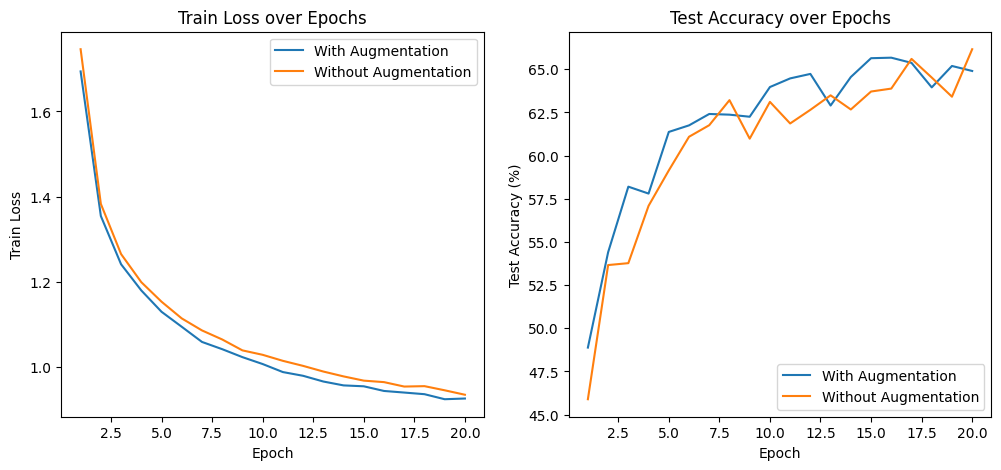

In [ ]:
# Функция обучения модели
def train_model(model, trainloader, testloader, optimizer, augmentation):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer

    train_loss_history = []
    test_accuracy_history = []

    for epoch in range(20):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Оценка модели на тестовом наборе данных после каждой эпохи
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracy = 100 * correct / total
        test_accuracy_history.append(test_accuracy)
        train_loss_history.append(running_loss / len(trainloader))

        print('Epoch [%d], Loss: %.4f, Test Accuracy: %.2f %%' %
              (epoch + 1, running_loss / len(trainloader), test_accuracy))

    return train_loss_history, test_accuracy_history

# Создаем экземпляры моделей с разными настройками аугментации данных
models = {
    'With Augmentation': CNN(),
    'Without Augmentation': CNN()
}

# Словари для хранения истории потерь и точности для каждой модели
train_loss_histories = {}
test_accuracy_histories = {}

# Обучаем каждую модель с каждым типом аугментации и сохраняем историю потерь и точности
for model_name, model in models.items():
    if model_name == 'With Augmentation':
        train_loss_histories[model_name], test_accuracy_histories[model_name] = train_model(model, trainloader_with_augmentation, testloader, optim.SGD(model.parameters(), lr=0.001, momentum=0.9), augmentation=True)
    else:
        train_loss_histories[model_name], test_accuracy_histories[model_name] = train_model(model, trainloader_with_augmentation, testloader, optim.SGD(model.parameters(), lr=0.001, momentum=0.9), augmentation=False)

# Построим графики для сравнения результатов
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for model_name, train_loss_history in train_loss_histories.items():
    plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label=model_name)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
for model_name, test_accuracy_history in test_accuracy_histories.items():
    plt.plot(range(1, len(test_accuracy_history) + 1), test_accuracy_history, label=model_name)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy over Epochs')
plt.legend()

plt.show()

In [ ]:
# model = CNN.to(device)
# summary(model, input_size=(3, 32, 32))

## Часть №4 Заключение (итоговая сеть, замер метрик)

In [2]:
# Загрузка CIFAR-10 данных и применение аугментации
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

100%|██████████| 170498071/170498071 [00:02<00:00, 80309118.95it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
# Разделение тренировочного набора данных на тренировочный и валидационный
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = random_split(trainset, [train_size, val_size])

# Загрузчики данных
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
valloader = DataLoader(valset, batch_size=32, shuffle=False)  # Изменяем размер батча на 32
testloader = DataLoader(testset, batch_size=128, shuffle=False)

# Определение модели
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        # Определение слоев CNN
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 256 * 4 * 4)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Функция обучения модели
def train_model(model, trainloader, valloader, optimizer):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    train_loss_history = []
    val_accuracy_history = []

    for epoch in range(30):  # Используем 10 эпох для примера
        model.train()  # Устанавливаем модель в режим обучения
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Оценка модели на валидационном наборе данных после каждой эпохи
        model.eval()  # Устанавливаем модель в режим оценки
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_accuracy_history.append(val_accuracy)
        train_loss_history.append(running_loss / len(trainloader))

        print('Epoch [%d], Loss: %.4f, Test Accuracy: %.2f %%' %
              (epoch + 1, running_loss / len(trainloader), val_accuracy))

    return train_loss_history, val_accuracy_history

# Создание экземпляра модели
model = DeepCNN()

# Оптимизатор и параметры обучения
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
train_loss_history, val_accuracy_history = train_model(model, trainloader, valloader, optimizer)


Epoch [1], Loss: 1.6059, Test Accuracy: 53.39 %
Epoch [2], Loss: 1.2248, Test Accuracy: 58.81 %
Epoch [3], Loss: 1.0276, Test Accuracy: 65.30 %
Epoch [4], Loss: 0.9034, Test Accuracy: 67.52 %
Epoch [5], Loss: 0.8091, Test Accuracy: 72.50 %
Epoch [6], Loss: 0.7532, Test Accuracy: 73.10 %
Epoch [7], Loss: 0.6955, Test Accuracy: 74.60 %
Epoch [8], Loss: 0.6567, Test Accuracy: 75.95 %
Epoch [9], Loss: 0.6169, Test Accuracy: 76.70 %
Epoch [10], Loss: 0.5855, Test Accuracy: 77.66 %
Epoch [11], Loss: 0.5593, Test Accuracy: 76.78 %
Epoch [12], Loss: 0.5345, Test Accuracy: 78.21 %
Epoch [13], Loss: 0.5036, Test Accuracy: 78.20 %
Epoch [14], Loss: 0.4839, Test Accuracy: 79.07 %
Epoch [15], Loss: 0.4641, Test Accuracy: 78.93 %
Epoch [16], Loss: 0.4517, Test Accuracy: 79.45 %
Epoch [17], Loss: 0.4283, Test Accuracy: 79.38 %
Epoch [18], Loss: 0.4088, Test Accuracy: 78.99 %
Epoch [19], Loss: 0.4002, Test Accuracy: 80.27 %
Epoch [20], Loss: 0.3834, Test Accuracy: 79.57 %
Epoch [21], Loss: 0.3730, Tes

In [4]:
# class DeepCNN(nn.Module):
#     def __init__(self):
#         super(DeepCNN, self).__init__()
#         # Определение слоев CNN
#         self.conv1 = nn.Conv2d(3, 1, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.fc1 = nn.Linear(256 * 4 * 4, 512)
#         self.fc2 = nn.Linear(512, 10)

#     def forward(self, x):
#         x = self.pool(nn.functional.relu(self.conv1(x)))
#         x = self.pool(nn.functional.relu(self.conv2(x)))
#         x = self.pool(nn.functional.relu(self.conv3(x)))
#         x = x.view(-1, 256 * 4 * 4)
#         x = nn.functional.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

In [ ]:
# Посмотрим на визуализацию струтктуры нейрнонной сети
# Предположим, что input_size = (3, 32, 32)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
       BatchNorm2d-5           [-1, 32, 16, 16]              64
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          18,496
       BatchNorm2d-8             [-1, 64, 8, 8]             128
         MaxPool2d-9             [-1, 64, 4, 4]               0
           Linear-10                  [-1, 256]         262,400
           Linear-11                   [-1, 10]           2,570
Total params: 288,778
Trainable params: 288,778
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

In [ ]:
model.conv1.bias.shape
# .weight.shape
# model.fc2.bias.shape

torch.Size([64])